In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
import random
import math
import scipy.stats as stats
import scipy.io 
import scipy.integrate as integrate
from numba import jit, int32
import numba
import time



In [2]:
#Model parameters

c1 = 0.5
xi = 8.5
q_c = 7
q_e = 0.093
tau_q = 15
T_mean = 16.6
alpha_q = q_c*q_e*np.exp(q_e*T_mean)/tau_q
gamma = 5.75

chi_A = 0.31
chi_O = 1.38

Q_mean = 0.9

dA = 0.1
dO = 0.5

re = 0.5
rw = 0.5

a = chi_O*c1*gamma
b = c1*xi*alpha_q

Q1 =  chi_A*alpha_q/(2 - 2*Q_mean)
Q2 =  chi_A*alpha_q/(3 - 3*Q_mean)



In [3]:
#Model initialization

LO = 6/5
LA = 8/3

NO = 50


xO = np.linspace(0,LO,NO)
dxO = xO[1] - xO[0]


t_f = 3*9.6
t_N = 960


t = np.linspace(0,t_f,t_N)
dt = t[1] - t[0]


W = 50
#W = 50

c1 = 0.5





r_K = np.exp(-dA*(LA-LO))
r_R = np.exp(3*dA*(LA-LO))

KA = np.zeros((W,t_N,NO))
RA = np.zeros((W,t_N,NO))
KA_sum = np.zeros((W,t_N,NO))
RA_sum = np.zeros((W,t_N,NO))

KO = np.zeros((W,t_N,NO))
RO = np.zeros((W,t_N,NO))

T = np.zeros((W,t_N,NO))



KO[0,0,:] = np.linspace(0.5, 0.25 ,NO)
RO[0,0,0] = (1/rw)*KO[0,0,0]
RO[0,0,NO-1] = re*KO[0,0,NO-1]
RO[0,0,:] = np.linspace(RO[0,0,0] , RO[0,0,NO-1]  ,NO)



T[0,0,:] = np.linspace(0.1, -0.1 ,NO)


V_K = np.zeros((W,t_N))
V_R = np.zeros((W,t_N))





OU_WCE = np.zeros((W,t_N))





#OU process parameters 
dp = 1.0
#dp = 0

sigma = 1.2
#sigma3 = 0

ap = -0.25
#ap = 0

eta = 1.5 + (0.5*np.tanh(7.5*(xO - LO/2)))
sp_x = np.exp(-45*(xO - LO/4)**2)
eps = 0.1

OU_WCE[:,0] = 0


drift = lambda y,t: -y*dp # define drift term, 
diffusion = lambda y,t: sigma # define diffusion term

In [4]:
for i in range(t_N-1):
    for w in range(0,W):
            if w == 0 :
                OU_WCE[w,i+1] = OU_WCE[w,i]  + drift(OU_WCE[w,i],i*dt)*dt + dp*ap*dt
            elif w == 1:
                OU_WCE[w,i+1] = OU_WCE[w,i]  + drift(OU_WCE[w,i],i*dt)*dt + dt*diffusion(OU_WCE[w,i],i*dt)*(1/np.sqrt(t_f))
            else :
                OU_WCE[w,i+1] = OU_WCE[w,i]  + drift(OU_WCE[w,i],i*dt)*dt + dt*diffusion(OU_WCE[w,i],i*dt)*np.sqrt(2/t_f)*np.cos(np.pi*(w-1)*t[i]/t_f)

In [5]:
start = time.time()
for i in range(t_N-1):
    for w in range(0,W):
            V_K[w,0] = sum(Q1*(np.exp(-dA*LO))*np.exp(dA*xO[j-1])*(T[w,0,j]+T[w,0,j-1])*dxO/2 for j in range(1,NO)) 
            V_R[w,0] = sum(-3*Q2*(np.exp(3*dA*LO))*np.exp(-3*dA*xO[j-1])*(T[w,0,j]+T[w,0,j-1])*dxO/2 for j in range(1,NO)) 
            for j in range(0,NO):
                KA[w,0,j] = V_K[w,0]*np.exp(-dA*xO[j])/(r_K - np.exp(-dA*LO)) + sum(Q1*np.exp(-dA*xO[j])*np.exp(dA*xO[k-1])*(T[w,0,k]+T[w,0,k-1])*dxO/2  for k in range(1,j+1)) 
                RA[w,0,j] = V_R[w,0]*np.exp(3*dA*xO[j])/(r_R - np.exp(3*dA*LO)) + sum(-3*Q2*np.exp(3*dA*xO[j])*np.exp(-3*dA*xO[k-1])*(T[w,0,k]+T[w,0,k-1])*dxO/2  for k in range(1,j+1))  
            for j in range(1,NO):  
                KO[w,i+1,j] = KO[w,i,j] - (c1)*(dt/dxO)*((KO[w,i,j] - KO[w,i,j-1])) - dt*dO*KO[w,i,j] + dt*(a/2)*(KA[w,i,j] - RA[w,i,j] + sp_x[j]*OU_WCE[w,i]) 
                KO[w,i+1,0] = KO[w,i,0] - (c1)*(dt/dxO)*(KO[w,i,0] - rw*RO[w,i,0])  - dt*dO*KO[w,i,0] + dt*(a/2)*(KA[w,i,0] - RA[w,i,0] + sp_x[0]*OU_WCE[w,i])                                                                                                                 
            for j in range(0,NO-1):
                RO[w,i+1,j] = RO[w,i,j] + (c1/3)*(dt/dxO)*((RO[w,i,j+1] - RO[w,i,j])) - dt*dO*RO[w,i,j] - dt*(a/3)*(KA[w,i,j] - RA[w,i,j]+ sp_x[j]*OU_WCE[w,i]) 
                RO[w,i+1,NO-1] = RO[w,i,NO-1] + (c1/3)*(dt/dxO)*(re*KO[w,i,NO-1] - RO[w,i,NO-1]) - dt*dO*RO[w,i,NO-1] - dt*(a/3)*(KA[w,i,NO-1] - RA[w,i,NO-1]+ sp_x[NO-1]*OU_WCE[w,i]) 
            for j in range(0,NO):    
                T[w,i+1,j] = T[w,i,j]  -  dt*b*T[w,i,j] + (c1)*(dt)*(eta[j])*(KO[w,i,j] + RO[w,i,j])
            V_K[w,i+1] = sum(Q1*(np.exp(-dA*LO))*np.exp(dA*xO[j-1])*(T[w,i+1,j]+T[w,i+1,j-1])*dxO/2 for j in range(1,NO))
            V_R[w,i+1] = sum(-3*Q2*(np.exp(3*dA*LO))*np.exp(-3*dA*xO[j-1])*(T[w,i+1,j]+T[w,i+1,j-1])*dxO/2 for j in range(1,NO))
            for j in range(0,NO):
                KA[w,i+1,j] = V_K[w,i+1]*np.exp(-dA*xO[j])/(r_K - np.exp(-dA*LO)) + sum( Q1*np.exp(-dA*xO[j])*np.exp(dA*xO[k-1])*(T[w,i+1,k]+T[w,i+1,k-1])*dxO/2  for k in range(1,j+1))
                RA[w,i+1,j] = V_R[w,i+1]*np.exp(3*dA*xO[j])/(r_R - np.exp(3*dA*LO)) + sum(-3*Q2*np.exp(3*dA*xO[j])*np.exp(-3*dA*xO[k-1])*(T[w,i+1,k]+T[w,i+1,k-1])*dxO/2  for k in range(1,j+1)) 
end = time.time()
print(end - start)                

801.5910015106201


In [6]:
scipy.io.savemat('Coupled_Linear_Propagators.mat', {'Kelvin_Atmosphere': KA, 'Rossby_Atmosphere' : RA, 'Kelvin_Ocean' : KO, 'Rossby_Ocean' : RO, 'Temperature' : T,'OU_WCE': OU_WCE ,'VK' : V_K, 'VR' : V_R}) 

In [7]:
KA = scipy.io.loadmat('Coupled_Linear_Propagators.mat')
RA = scipy.io.loadmat('Coupled_Linear_Propagators.mat')
KO = scipy.io.loadmat('Coupled_Linear_Propagators.mat')
RO = scipy.io.loadmat('Coupled_Linear_Propagators.mat')
T = scipy.io.loadmat('Coupled_Linear_Propagators.mat')
OU_WCE = scipy.io.loadmat('Coupled_Linear_Propagators.mat')
V_K = scipy.io.loadmat('Coupled_Linear_Propagators.mat')
V_R = scipy.io.loadmat('Coupled_Linear_Propagators.mat')


KA = KA['Kelvin_Atmosphere']
RA = RA['Rossby_Atmosphere']
KO = KO['Kelvin_Ocean']
RO = RO['Rossby_Ocean']
T = T['Temperature']
OU_WCE = OU_WCE['OU_WCE']
V_K = V_K['VK']
V_R = V_R['VR']


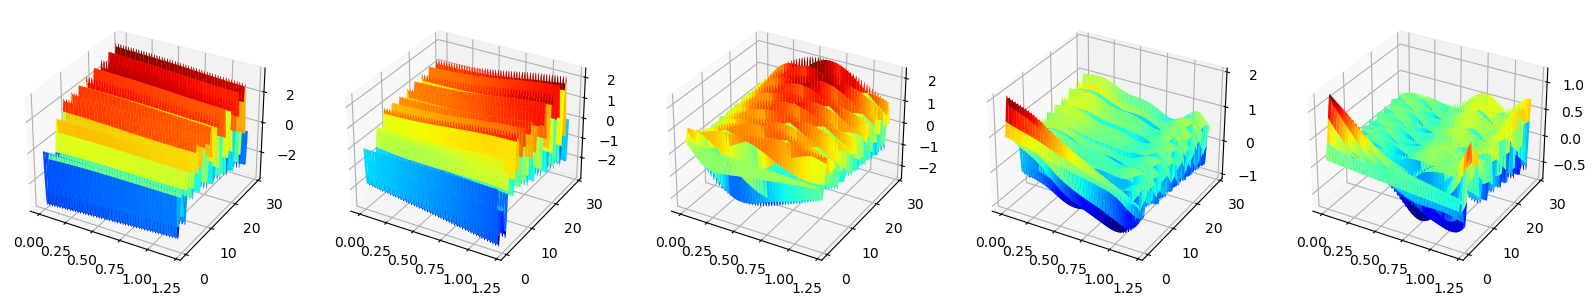

In [8]:
import matplotlib.pyplot as plt
import numpy as np



# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=(20,4))
X1, Y1 = np.meshgrid(xO,t)


ax = fig.add_subplot(1, 5, 1, projection='3d')
ax.plot_surface(X1, Y1, KA[0,:,:],cmap='jet')

# ==============
# Second subplot
# ==============
# set up the axes for the second plot
ax = fig.add_subplot(1, 5, 2, projection='3d')
ax.plot_surface(X1, Y1, RA[0,:,:], cmap='jet')

ax = fig.add_subplot(1, 5, 3, projection='3d')
ax.plot_surface(X1, Y1, KO[0,:,:], cmap='jet')

ax = fig.add_subplot(1, 5, 4, projection='3d')
ax.plot_surface(X1, Y1, RO[0,:,:], cmap='jet')

ax = fig.add_subplot(1, 5, 5, projection='3d')
ax.plot_surface(X1, Y1, T[0,:,:], cmap='jet')

#plt.savefig("Problem3_3D_Homogeneous.png")
plt.show()

In [9]:
KA_variance_W = np.zeros((t_N,NO))
RA_variance_W = np.zeros((t_N,NO))
KO_variance_W = np.zeros((t_N,NO))
RO_variance_W = np.zeros((t_N,NO))
T_variance_W = np.zeros((t_N,NO))


for i in range(t_N):
    for j in range(0,NO):    
        for w in range(1,W):
            KA_variance_W[i,j] += KA[w,i,j]**2
            RA_variance_W[i,j] += RA[w,i,j]**2  
            KO_variance_W[i,j] += KO[w,i,j]**2
            RO_variance_W[i,j] += RO[w,i,j]**2  
            T_variance_W[i,j] += T[w,i,j]**2

In [10]:
scipy.io.savemat('Coupled_Linear_WCE_Variance.mat', {'KA_variance': KA_variance_W, 'RA_variance' : RA_variance_W, 'KO_variance' : KO_variance_W, 'RO_variance' : RO_variance_W, 'T_variance' : T_variance_W}) 

In [18]:
T_variance  = scipy.io.loadmat('Coupled_Linear_Variance.mat')
T_variance = T_variance['T_variance']

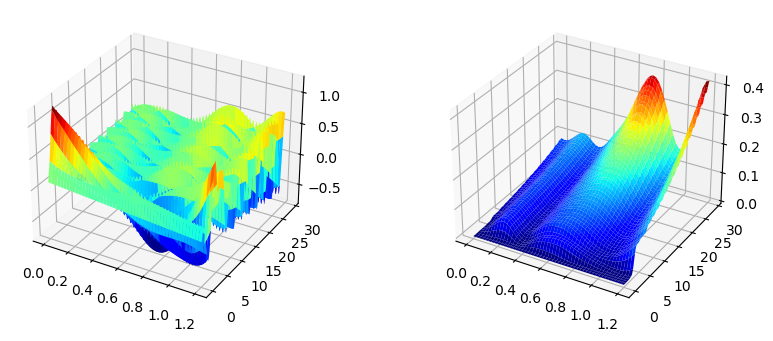

In [20]:
import matplotlib.pyplot as plt
import numpy as np



# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=(10,4))
X1, Y1 = np.meshgrid(xO,t)


ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(X1, Y1, T[0,:,:],cmap='jet')

# ==============
# Second subplot
# ==============
# set up the axes for the second plot
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_surface(X1, Y1, T_variance[:,:], cmap='jet')


#plt.savefig("Problem3_3D_Homogeneous.png")
plt.show()

In [ ]:
start = time.time()
for i in range(t_N-1):
    for w in range(0,W):
        if w == 0 :
            V_K[w,0] = sum(Q1*(np.exp(-dA*LO))*np.exp(dA*xO[j-1])*(T[w,0,j]+T[w,0,j-1])*dxO/2 for j in range(1,NO)) 
            V_R[w,0] = sum(-3*Q2*(np.exp(3*dA*LO))*np.exp(-3*dA*xO[j-1])*(T[w,0,j]+T[w,0,j-1])*dxO/2 for j in range(1,NO)) 
            for j in range(0,NO):
                KA[w,0,j] = V_K[w,0]*np.exp(-dA*xO[j])/(r_K - np.exp(-dA*LO)) + sum(Q1*np.exp(-dA*xO[j])*np.exp(dA*xO[k-1])*(T[w,0,k]+T[w,0,k-1])*dxO/2  for k in range(1,j+1)) 
                RA[w,0,j] = V_R[w,0]*np.exp(3*dA*xO[j])/(r_R - np.exp(3*dA*LO)) + sum(-3*Q2*np.exp(3*dA*xO[j])*np.exp(-3*dA*xO[k-1])*(T[w,0,k]+T[w,0,k-1])*dxO/2  for k in range(1,j+1))  
            for j in range(1,NO):  
                KO[w,i+1,j] = KO[w,i,j] - (c1)*(dt/dxO)*((KO[w,i,j] - KO[w,i,j-1])) - dt*dO*KO[w,i,j] + dt*(a/2)*(KA[w,i,j] - RA[w,i,j] + sp_x[j]*OU_WCE[w,i]) 
                KO[w,i+1,0] = KO[w,i,0] - (c1)*(dt/dxO)*(KO[w,i,0] - rw*RO[w,i,0])  - dt*dO*KO[w,i,0] + dt*(a/2)*(KA[w,i,0] - RA[w,i,0] + sp_x[0]*OU_WCE[w,i])                                                                                                                 
            for j in range(0,NO-1):
                RO[w,i+1,j] = RO[w,i,j] + (c1/3)*(dt/dxO)*((RO[w,i,j+1] - RO[w,i,j])) - dt*dO*RO[w,i,j] - dt*(a/3)*(KA[w,i,j] - RA[w,i,j]+ sp_x[j]*OU_WCE[w,i]) 
                RO[w,i+1,NO-1] = RO[w,i,NO-1] + (c1/3)*(dt/dxO)*(re*KO[w,i,NO-1] - RO[w,i,NO-1]) - dt*dO*RO[w,i,NO-1] - dt*(a/3)*(KA[w,i,NO-1] - RA[w,i,NO-1]+ sp_x[NO-1]*OU_WCE[w,i]) 
            for j in range(0,NO):    
                T[w,i+1,j] = T[w,i,j]  -  dt*b*T[w,i,j] + (c1)*(dt)*(eta[j])*(KO[w,i,j] + RO[w,i,j])
            V_K[w,i+1] = sum(Q1*(np.exp(-dA*LO))*np.exp(dA*xO[j-1])*(T[w,i+1,j]+T[w,i+1,j-1])*dxO/2 for j in range(1,NO))
            V_R[w,i+1] = sum(-3*Q2*(np.exp(3*dA*LO))*np.exp(-3*dA*xO[j-1])*(T[w,i+1,j]+T[w,i+1,j-1])*dxO/2 for j in range(1,NO))
            for j in range(0,NO):
                KA[w,i+1,j] = V_K[w,i+1]*np.exp(-dA*xO[j])/(r_K - np.exp(-dA*LO)) + sum( Q1*np.exp(-dA*xO[j])*np.exp(dA*xO[k-1])*(T[w,i+1,k]+T[w,i+1,k-1])*dxO/2  for k in range(1,j+1))
                RA[w,i+1,j] = V_R[w,i+1]*np.exp(3*dA*xO[j])/(r_R - np.exp(3*dA*LO)) + sum(-3*Q2*np.exp(3*dA*xO[j])*np.exp(-3*dA*xO[k-1])*(T[w,i+1,k]+T[w,i+1,k-1])*dxO/2  for k in range(1,j+1)) 
        elif w == 1 :
            V_K[w,0] = sum(Q1*(np.exp(-dA*LO))*np.exp(dA*xO[j-1])*(T[w,0,j]+T[w,0,j-1])*dxO/2 for j in range(1,NO)) 
            V_R[w,0] = sum(-3*Q2*(np.exp(3*dA*LO))*np.exp(-3*dA*xO[j-1])*(T[w,0,j]+T[w,0,j-1])*dxO/2 for j in range(1,NO)) 
            for j in range(0,NO):
                KA[w,0,j] = V_K[w,0]*np.exp(-dA*xO[j])/(r_K - np.exp(-dA*LO)) + sum(Q1*np.exp(-dA*xO[j])*np.exp(dA*xO[k-1])*(T[w,0,k]+T[w,0,k-1])*dxO/2  for k in range(1,j+1)) 
                RA[w,0,j] = V_R[w,0]*np.exp(3*dA*xO[j])/(r_R - np.exp(3*dA*LO)) + sum(-3*Q2*np.exp(3*dA*xO[j])*np.exp(-3*dA*xO[k-1])*(T[w,0,k]+T[w,0,k-1])*dxO/2  for k in range(1,j+1))  
            for j in range(1,NO):  
                KO[w,i+1,j] = KO[w,i,j] - (c1)*(dt/dxO)*((KO[w,i,j] - KO[w,i,j-1])) - dt*dO*KO[w,i,j] + dt*(a/2)*(KA[w,i,j] - RA[w,i,j] + sp_x[j]*OU_WCE[w,i]) 
                KO[w,i+1,0] = KO[w,i,0] - (c1)*(dt/dxO)*(KO[w,i,0] - rw*RO[w,i,0])  - dt*dO*KO[w,i,0] + dt*(a/2)*(KA[w,i,0] - RA[w,i,0] + sp_x[0]*OU_WCE[w,i])                                                                                                                 
            for j in range(0,NO-1):
                RO[w,i+1,j] = RO[w,i,j] + (c1/3)*(dt/dxO)*((RO[w,i,j+1] - RO[w,i,j])) - dt*dO*RO[w,i,j] - dt*(a/3)*(KA[w,i,j] - RA[w,i,j]+ sp_x[j]*OU_WCE[w,i]) 
                RO[w,i+1,NO-1] = RO[w,i,NO-1] + (c1/3)*(dt/dxO)*(re*KO[w,i,NO-1] - RO[w,i,NO-1]) - dt*dO*RO[w,i,NO-1] - dt*(a/3)*(KA[w,i,NO-1] - RA[w,i,NO-1]+ sp_x[NO-1]*OU_WCE[w,i]) 
            for j in range(0,NO):    
                T[w,i+1,j] = T[w,i,j]  -  dt*b*T[w,i,j] + (c1)*(dt)*(eta[j])*(KO[w,i,j] + RO[w,i,j])
            V_K[w,i+1] = sum(Q1*(np.exp(-dA*LO))*np.exp(dA*xO[j-1])*(T[w,i+1,j]+T[w,i+1,j-1])*dxO/2 for j in range(1,NO))
            V_R[w,i+1] = sum(-3*Q2*(np.exp(3*dA*LO))*np.exp(-3*dA*xO[j-1])*(T[w,i+1,j]+T[w,i+1,j-1])*dxO/2 for j in range(1,NO))
            for j in range(0,NO):
                KA[w,i+1,j] = V_K[w,i+1]*np.exp(-dA*xO[j])/(r_K - np.exp(-dA*LO)) + sum( Q1*np.exp(-dA*xO[j])*np.exp(dA*xO[k-1])*(T[w,i+1,k]+T[w,i+1,k-1])*dxO/2  for k in range(1,j+1))
                RA[w,i+1,j] = V_R[w,i+1]*np.exp(3*dA*xO[j])/(r_R - np.exp(3*dA*LO)) + sum(-3*Q2*np.exp(3*dA*xO[j])*np.exp(-3*dA*xO[k-1])*(T[w,i+1,k]+T[w,i+1,k-1])*dxO/2  for k in range(1,j+1))        
        else :
            V_K[w,0] = sum(Q1*(np.exp(-dA*LO))*np.exp(dA*xO[j-1])*(T[w,0,j]+T[w,0,j-1])*dxO/2 for j in range(1,NO)) 
            V_R[w,0] = sum(-3*Q2*(np.exp(3*dA*LO))*np.exp(-3*dA*xO[j-1])*(T[w,0,j]+T[w,0,j-1])*dxO/2 for j in range(1,NO)) 
            for j in range(0,NO):
                KA[w,0,j] = V_K[w,0]*np.exp(-dA*xO[j])/(r_K - np.exp(-dA*LO)) + sum(Q1*np.exp(-dA*xO[j])*np.exp(dA*xO[k-1])*(T[w,0,k]+T[w,0,k-1])*dxO/2  for k in range(1,j+1)) 
                RA[w,0,j] = V_R[w,0]*np.exp(3*dA*xO[j])/(r_R - np.exp(3*dA*LO)) + sum(-3*Q2*np.exp(3*dA*xO[j])*np.exp(-3*dA*xO[k-1])*(T[w,0,k]+T[w,0,k-1])*dxO/2  for k in range(1,j+1))  
            for j in range(1,NO):  
                KO[w,i+1,j] = KO[w,i,j] - (c1)*(dt/dxO)*((KO[w,i,j] - KO[w,i,j-1])) - dt*dO*KO[w,i,j] + dt*(a/2)*(KA[w,i,j] - RA[w,i,j] + sp_x[j]*OU_WCE[w,i]) 
                KO[w,i+1,0] = KO[w,i,0] - (c1)*(dt/dxO)*(KO[w,i,0] - rw*RO[w,i,0])  - dt*dO*KO[w,i,0] + dt*(a/2)*(KA[w,i,0] - RA[w,i,0] + sp_x[0]*OU_WCE[w,i])                                                                                                                 
            for j in range(0,NO-1):
                RO[w,i+1,j] = RO[w,i,j] + (c1/3)*(dt/dxO)*((RO[w,i,j+1] - RO[w,i,j])) - dt*dO*RO[w,i,j] - dt*(a/3)*(KA[w,i,j] - RA[w,i,j]+ sp_x[j]*OU_WCE[w,i]) 
                RO[w,i+1,NO-1] = RO[w,i,NO-1] + (c1/3)*(dt/dxO)*(re*KO[w,i,NO-1] - RO[w,i,NO-1]) - dt*dO*RO[w,i,NO-1] - dt*(a/3)*(KA[w,i,NO-1] - RA[w,i,NO-1]+ sp_x[NO-1]*OU_WCE[w,i]) 
            for j in range(0,NO):    
                T[w,i+1,j] = T[w,i,j]  -  dt*b*T[w,i,j] + (c1)*(dt)*(eta[j])*(KO[w,i,j] + RO[w,i,j])
            V_K[w,i+1] = sum(Q1*(np.exp(-dA*LO))*np.exp(dA*xO[j-1])*(T[w,i+1,j]+T[w,i+1,j-1])*dxO/2 for j in range(1,NO))
            V_R[w,i+1] = sum(-3*Q2*(np.exp(3*dA*LO))*np.exp(-3*dA*xO[j-1])*(T[w,i+1,j]+T[w,i+1,j-1])*dxO/2 for j in range(1,NO))
            for j in range(0,NO):
                KA[w,i+1,j] = V_K[w,i+1]*np.exp(-dA*xO[j])/(r_K - np.exp(-dA*LO)) + sum( Q1*np.exp(-dA*xO[j])*np.exp(dA*xO[k-1])*(T[w,i+1,k]+T[w,i+1,k-1])*dxO/2  for k in range(1,j+1))
                RA[w,i+1,j] = V_R[w,i+1]*np.exp(3*dA*xO[j])/(r_R - np.exp(3*dA*LO)) + sum(-3*Q2*np.exp(3*dA*xO[j])*np.exp(-3*dA*xO[k-1])*(T[w,i+1,k]+T[w,i+1,k-1])*dxO/2  for k in range(1,j+1)) 
print(end - start)                